<a href="https://colab.research.google.com/github/Hamdan070905/-Fraud-Detection-in-Credit-Card-Transactions/blob/main/Fraud_Detection_in_Credit_Card_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("creditcard.csv")
print(df.head())
print(df['Class'].value_counts())  # 0 = Normal, 1 = Fraud


   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [3]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df.drop(['Time'], axis=1, inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']
print(X.shape, y.shape)


(23323, 29) (23323,)


In [8]:
X = X.dropna()
y = y[X.index]

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # or 'median'
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

from sklearn.neighbors import LocalOutlierFactor

iso_forest = IsolationForest(contamination=0.001)
y_pred_iso = iso_forest.fit_predict(X)
y_pred_iso = [1 if i == -1 else 0 for i in y_pred_iso]


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.001)
y_pred_lof = lof.fit_predict(X)
y_pred_lof = [1 if i == -1 else 0 for i in y_pred_lof]

print("Isolation Forest:\n", confusion_matrix(y, y_pred_iso))
print("Local Outlier Factor:\n", confusion_matrix(y, y_pred_lof))


print(X.isnull().sum().sum())



Isolation Forest:
 [[23230     5]
 [   68    19]]
Local Outlier Factor:
 [[23211    24]
 [   87     0]]
0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train,X_test, y_train, y_test)

             V1        V2        V3        V4        V5        V6        V7  \
17826  1.298296 -0.890844  1.177912 -0.407019 -1.699650 -0.410841 -1.150076   
356    1.260328  0.299161  0.527681  0.614899 -0.420592 -0.977533  0.108485   
2422  -2.624649 -1.920821  3.419228  1.216409 -0.213411  0.605521 -0.203789   
18921 -2.168570 -1.964947  0.288038 -2.184667 -0.411686 -0.717255 -0.583060   
11619 -0.835969  0.424841  2.191436 -0.413210 -0.542720 -0.238319  0.185999   
...         ...       ...       ...       ...       ...       ...       ...   
18934 -0.903993  0.207597  1.658510  0.152728  0.532681  0.544890  0.701423   
21302 -0.667901 -0.067322  0.913088 -2.564702 -1.098467 -0.660326 -0.630405   
20406 -4.064560  1.663548  0.701321 -1.899059  0.245438 -0.915223  1.405746   
13345 -1.118615 -0.532640  2.795817 -0.090502 -0.490425  0.608232  0.128766   
11876  1.067912 -0.147216  0.244017  0.139686 -0.090984  0.122657 -0.216739   

             V8        V9       V10  ...       V20 

In [15]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

[[4644    4]
 [   1   16]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4648
         1.0       0.80      0.94      0.86        17

    accuracy                           1.00      4665
   macro avg       0.90      0.97      0.93      4665
weighted avg       1.00      1.00      1.00      4665

0.9701579426951503


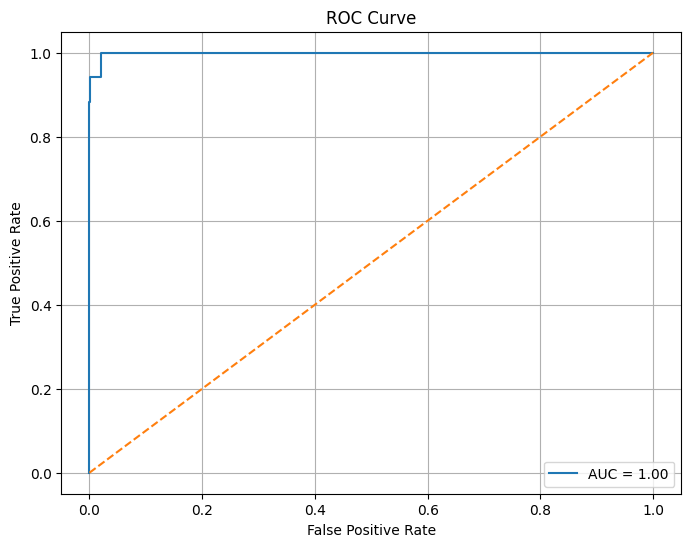

In [11]:
y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [16]:
import joblib
joblib.dump(model, 'xgb_model.pkl')


['xgb_model.pkl']

In [17]:
from google.colab import files
files.download('xgb_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>